# Plot FWC, OHC, MLD, SIC when ice bridge is present over Mackenzie Plume

In [1]:
## import required packages
import numpy as np
import pandas as pd
import sys
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import cmocean
import gsw
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import datetime
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore", module='distributed')

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39367")
client

<Client: 'tcp://127.0.0.1:39367' processes=8 threads=32, memory=123.95 GiB>

In [3]:
# initialize s3 filesystem
s3_options = dict(anon=False)

In [4]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [5]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

### Open daily mean ZARR datasets

In [6]:
# open SALT zarr store - [psu]
SALT_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SALT_AVG_DAILY.ZARR/', s3_options)

# open THETA zarr store - [degC]
THETA_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/THETA_AVG_DAILY.ZARR/', s3_options)

# open SIarea zarr store - [fraction of sea ice, 0 to 1]
SI_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SIarea_AVG_DAILY.ZARR/', s3_options)

# open HEFF zarr store
heff_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SIheff_AVG_DAILY.ZARR/', s3_options)

In [7]:
# remove 2021 since we only have January and a few days in Feb that year
salt_day = SALT_zarr_day.SALT.sel(time=slice("2014","2020")).where(HH_grid.mask_basin==1)
theta_day = THETA_zarr_day.THETA.sel(time=slice("2014","2020")).where(HH_grid.mask_basin==1)
ice_day = SI_zarr_day.SIarea.sel(time=slice("2014","2020")).where(HH_grid.mask_basin.isel(k=0)==1)*100 # convert to percentage

In [8]:
HH_grid_land = HH_grid.maskC.isel(k=0).where(HH_grid.maskC.isel(k=0)==0)

### Manual dates

In [9]:
ice_dates_plume = np.array(['2014-10-29T12',
                            '2015-10-11T12',
                            '2016-10-22T12',
                            '2017-10-26T12',
                            '2018-10-13T12',
                            '2019-10-26T12',
                            '2020-10-25T12'], dtype='datetime64[ns]')

In [10]:
ice_dates_plume

array(['2014-10-29T12:00:00.000000000', '2015-10-11T12:00:00.000000000',
       '2016-10-22T12:00:00.000000000', '2017-10-26T12:00:00.000000000',
       '2018-10-13T12:00:00.000000000', '2019-10-26T12:00:00.000000000',
       '2020-10-25T12:00:00.000000000'], dtype='datetime64[ns]')

### open datasets

In [11]:
# open OHC zarr stores
fwc_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_Beaufort_final.ZARR')
fwc_da = fwc_ds.fwc

ohc_mld_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_MLD_Beaufort_final.ZARR')
ohc_mld_da = ohc_mld_ds.ohc

ohc_pyc_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_PYC_Beaufort_final.ZARR')
ohc_pyc_da = ohc_pyc_ds.ohc_pyc

mld_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/MLD/MLD_Beaufort_final.ZARR')
mld_da = mld_ds.mld

In [12]:
# select just beaufort region and ice date for each year
fwc_icedays = fwc_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
ohc_mld_icedays = ohc_mld_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
ohc_pyc_icedays = ohc_pyc_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
mld_icedays = mld_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
sic_icedays = ice_day.sel(time=ice_dates_plume).isel(i=slice(510,750),j=slice(110,390))

In [13]:
# select only beaufort land and bathy
land_beaufort = HH_grid_land.isel(i=slice(510,750),j=slice(110,390))
bathy_beaufort = HH_grid.isel(i=slice(510,750),j=slice(110,390)).Depth

In [14]:
# rotate arrays
land_flip = xr.DataArray(np.rot90(land_beaufort,3), dims=['i','j'])
bathy_flip = xr.DataArray(np.rot90(bathy_beaufort,3), dims=['i','j']).load()

rotated_data = xr.DataArray(np.rot90(fwc_icedays,3, axes=(1, 2)))
fwc_flip = xr.DataArray(rotated_data, dims=['time', 'i', 'j']).load()

rotated_data = xr.DataArray(np.rot90(ohc_mld_icedays,3, axes=(1, 2)))
ohc_mld_flip = xr.DataArray(rotated_data, dims=['time', 'i', 'j']).load()

rotated_data = xr.DataArray(np.rot90(ohc_pyc_icedays,3, axes=(1, 2)))
ohc_pyc_flip = xr.DataArray(rotated_data, dims=['time', 'i', 'j']).load()

rotated_data = xr.DataArray(np.rot90(mld_icedays,3, axes=(1, 2)))
mld_flip = (xr.DataArray(rotated_data, dims=['time', 'i', 'j'])*-1).load()

rotated_data = xr.DataArray(np.rot90(sic_icedays,3, axes=(1, 2)))
sic_flip = xr.DataArray(rotated_data, dims=['time', 'i', 'j']).load()

### Make a custom sea ice colormap

In [15]:
from matplotlib.colors import LinearSegmentedColormap

# Function to truncate colormap
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

In [16]:
# truncate the cmocean ice colormap to avoid very dark colors
trunc_ice = truncate_colormap(cmocean.cm.ice, minval=0.2, maxval=1.0)

In [17]:
def remap_colormap(cmap, nonlin_scale=np.sqrt, n=256):
    """
    Remap a colormap so that lower values are compressed (darker colors take up less space),
    and higher values (lighter colors) are stretched out.
    
    Parameters:
    - cmap: The original colormap (e.g., cmocean.cm.ice)
    - nonlin_scale: A function that maps [0,1] -> [0,1] nonlinearly (default: np.sqrt)
    - n: Number of color levels
    
    Returns:
    - A new colormap with redistributed colors.
    """
    # Generate linearly spaced values, then apply non-linear scaling
    orig_vals = np.linspace(0, 1, n)
    remapped_vals = nonlin_scale(orig_vals)

    # Normalize remapped values to stay in [0,1]
    remapped_vals = (remapped_vals - remapped_vals.min()) / (remapped_vals.max() - remapped_vals.min())

    # Map those values through the original colormap
    new_colors = cmap(remapped_vals)
    
    return LinearSegmentedColormap.from_list(f'remapped_{cmap.name}', new_colors, N=n)

In [18]:
# create a nonlinearly adjusted colormap from the cmocean ice colormap
custom_cmap = remap_colormap(cmocean.cm.ice, nonlin_scale=np.sqrt)  # sqrt compresses low end

### Plot map of SIC, FWC, OHC, and MLD

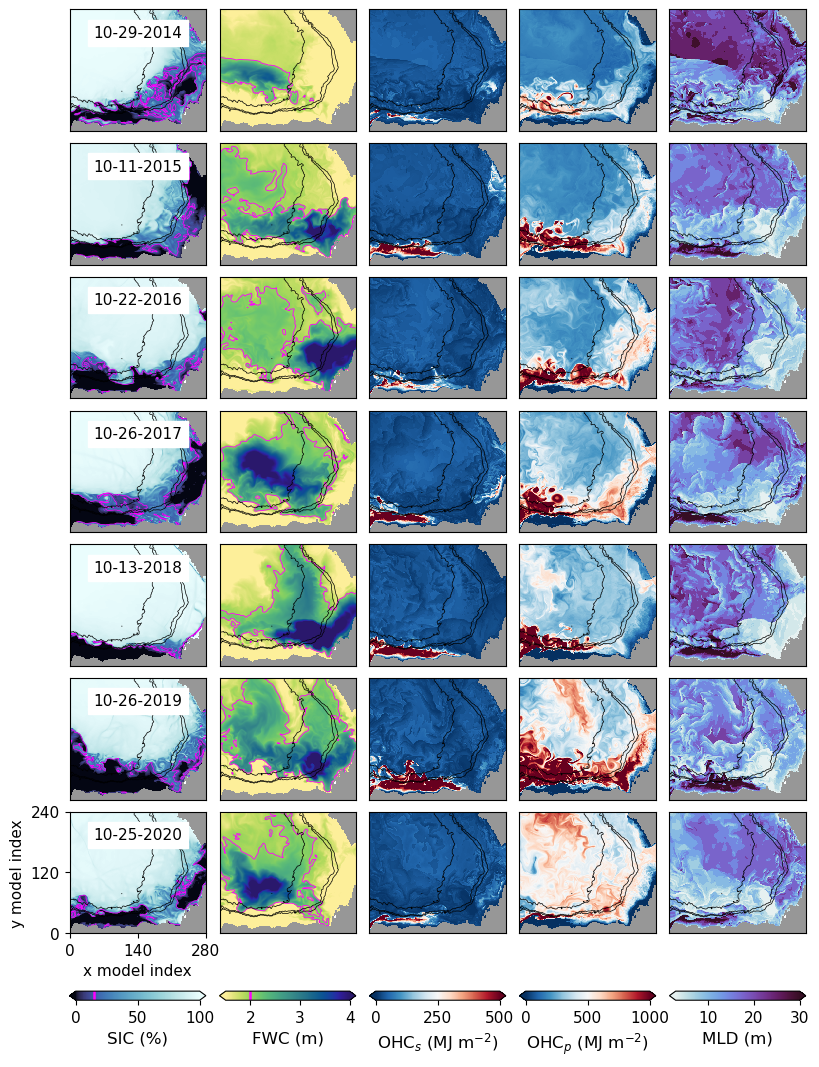

In [19]:
# Set up the figure and subplots (7 rows for years, 4 columns for variables)
plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(7, 5, figsize=(9.5, 15),gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
# fig.set_constrained_layout_pads(hspace=0.05, wspace=0.08)

# Define the colormap and range for each dataset
vmin_fwc, vmax_fwc = 1.5, 4
vmin_ohc_mld, vmax_ohc_mld = 0, 500
vmin_ohc_pyc, vmax_ohc_pyc = 0, 1000
vmin_mld, vmax_mld = 3, 30
vmin_sic, vmax_sic = 0, 100

# Loop through each year and plot all variables (columns: FWC, OHC, MLD, SIC)
for year in range(7):
    # Format the date string
    date_str = datetime.datetime.strptime(str(fwc_icedays.isel(time=year).time.values)[0:10], '%Y-%m-%d').strftime('%m-%d-%Y')

    # Column 0: SIC
    ax = axes[year, 0]
    sic_flip.isel(time=year).plot(ax=ax, cmap=custom_cmap, vmin=vmin_sic, vmax=vmax_sic, add_colorbar=False)
    sic_flip.isel(time=year).plot.contour(ax=ax, levels=[15], linewidths=0.5, colors='magenta', add_colorbar=False)
    land_flip.plot(ax=ax, cmap='Greys_r', add_colorbar=False)
    bathy_flip.plot.contour(ax=ax, colors='k', linewidths=0.5, levels=[500, 1000, 3000])
    ax.set_ylabel(date_str, fontsize=14)

    # Add date as a text box with white background at bottom center
    ax.text(0.5, 0.87, date_str, transform=ax.transAxes,
            ha='center', va='top', fontsize=11, color='black',
            bbox=dict(facecolor='white', edgecolor='white'))

    # Column 1: FWC
    ax = axes[year, 1]
    fwc_flip.isel(time=year).plot(ax=ax, cmap=cmocean.cm.haline_r, vmin=vmin_fwc, vmax=vmax_fwc, add_colorbar=False)
    fwc_flip.isel(time=year).plot.contour(ax=ax, levels=[2], linewidths=0.6, colors='magenta', add_colorbar=False)
    land_flip.plot(ax=ax, cmap='Greys_r', add_colorbar=False)
    bathy_flip.plot.contour(ax=ax, colors='k', linewidths=0.5, levels=[500, 1000, 3000])

    # Column 2: OHC_s
    ax = axes[year, 2]
    (ohc_mld_flip.isel(time=year)/1e6).plot(ax=ax, cmap='RdBu_r', vmin=vmin_ohc_mld, vmax=vmax_ohc_mld, add_colorbar=False)
    land_flip.plot(ax=ax, cmap='Greys_r', add_colorbar=False)
    bathy_flip.plot.contour(ax=ax, colors='k', linewidths=0.5, levels=[500, 1000, 3000])

    # Column 3: OHC_p
    ax = axes[year, 3]
    (ohc_pyc_flip.isel(time=year)/1e6).plot(ax=ax, cmap='RdBu_r', vmin=vmin_ohc_pyc, vmax=vmax_ohc_pyc, add_colorbar=False)
    land_flip.plot(ax=ax, cmap='Greys_r', add_colorbar=False)
    bathy_flip.plot.contour(ax=ax, colors='k', linewidths=0.5, levels=[500, 1000, 3000])

    # Column 4: MLD
    ax = axes[year, 4]
    mld_flip.isel(time=year).plot(ax=ax, cmap=cmocean.cm.dense, vmin=vmin_mld, vmax=vmax_mld, add_colorbar=False)
    land_flip.plot(ax=ax, cmap='Greys_r', add_colorbar=False)
    bathy_flip.plot.contour(ax=ax, colors='k', linewidths=0.5, levels=[500, 1000, 3000])

# Remove axis titles for all subplots
for ax in axes.flatten():
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_xticks([])

axes[year, 0].set_yticks([0,120,240])
axes[year, 0].set_xticks([0,140,280])
axes[year, 0].set_ylabel("y model index",size=11)
axes[year, 0].set_xlabel("x model index",size=11)

# Leave space for colorbars
# fig.subplots_adjust(bottom=0.12)

# Add horizontal colorbars below each column
colorbars = [(custom_cmap, vmin_sic, vmax_sic, 'SIC (%)', 0, 15),
             (cmocean.cm.haline_r, vmin_fwc, vmax_fwc, 'FWC (m)', 1, 2),
             ('RdBu_r', vmin_ohc_mld, vmax_ohc_mld, 'OHC$_s$ (MJ m$^{-2}$)', 2, None),
             ('RdBu_r', vmin_ohc_pyc, vmax_ohc_pyc, 'OHC$_p$ (MJ m$^{-2}$)', 3, None),
             (cmocean.cm.dense, vmin_mld, vmax_mld, 'MLD (m)', 4, None)]

for cmap, vmin, vmax, label, col, contour_val in colorbars:
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=axes[:, col],  # all rows in this column
        orientation='horizontal',
        pad=0.05,
        aspect=15,
        extend='both'
    )
    cbar.set_label(label, fontsize=12)
    if contour_val is not None:
        # rel_pos = contour_val - vmin) / (vmax - vmin)
        cbar.ax.axvline(contour_val, color='magenta', linewidth=1.8)

    # If this is the second column (FWC), set custom tick labels
    if col == 1:
        cbar.set_ticks([2, 3, 4])
        cbar.set_ticklabels(['2', '3', '4'])

# Set main title
# plt.suptitle('Manually selected dates when ice bridge was observed', fontsize=14, y=1.03)

plt.show()

fig.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/figS1.png', \
            dpi=300, bbox_inches='tight')